INFO:__main__:
[VaR Results at 95% Confidence Level]
INFO:__main__:Historical          : $0.033087
INFO:__main__:Parametric Normal   : $0.054738
INFO:__main__:Parametric Student-t: $0.034869
INFO:__main__:GARCH               : $0.050121
INFO:__main__:Filtered Historical : $0.037119
INFO:__main__:Monte Carlo         : $0.049927
INFO:__main__:CVaR:                 $0.046607
INFO:__main__:10-day VaR (sqrt):       $0.110265
INFO:__main__:True 10-day MC VaR:        $0.087518
INFO:__main__:
[VaR Results at 99% Confidence Level]
INFO:__main__:Historical          : $0.053327
INFO:__main__:Parametric Normal   : $0.077926
INFO:__main__:Parametric Student-t: $0.055875
INFO:__main__:GARCH               : $0.071396
INFO:__main__:Filtered Historical : $0.060399
INFO:__main__:Monte Carlo         : $0.071033
INFO:__main__:CVaR:                 $0.070261
INFO:__main__:10-day VaR (sqrt):       $0.176692
INFO:__main__:True 10-day MC VaR:        $0.136291
INFO:__main__:
[Performance Metrics]
INFO:__main__

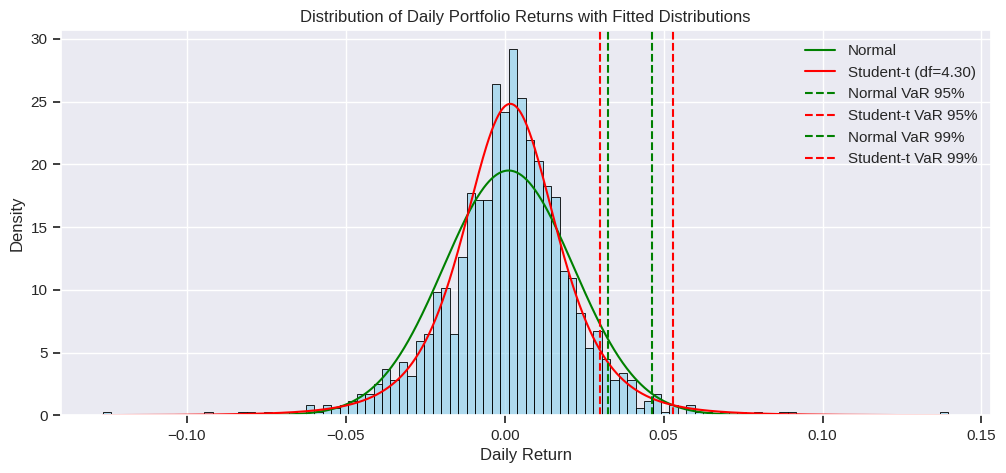

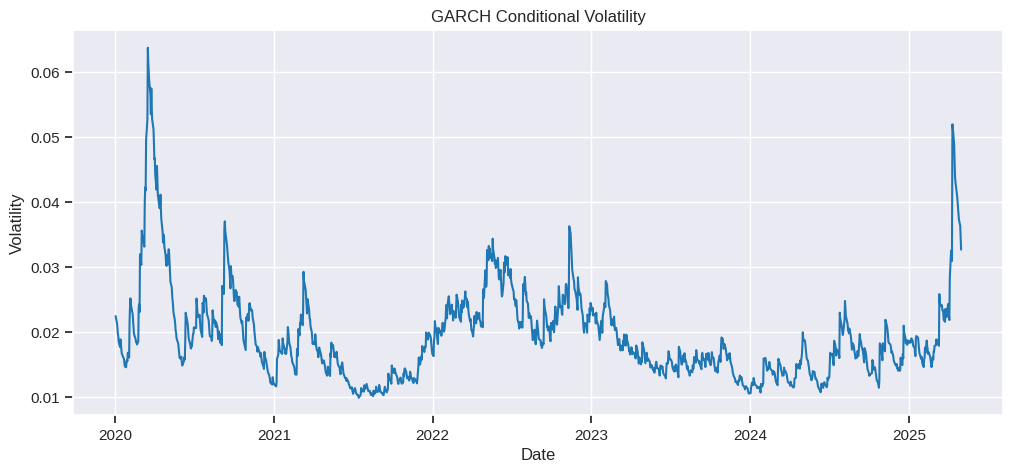

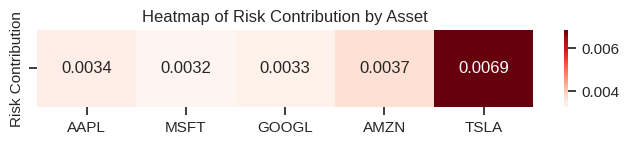

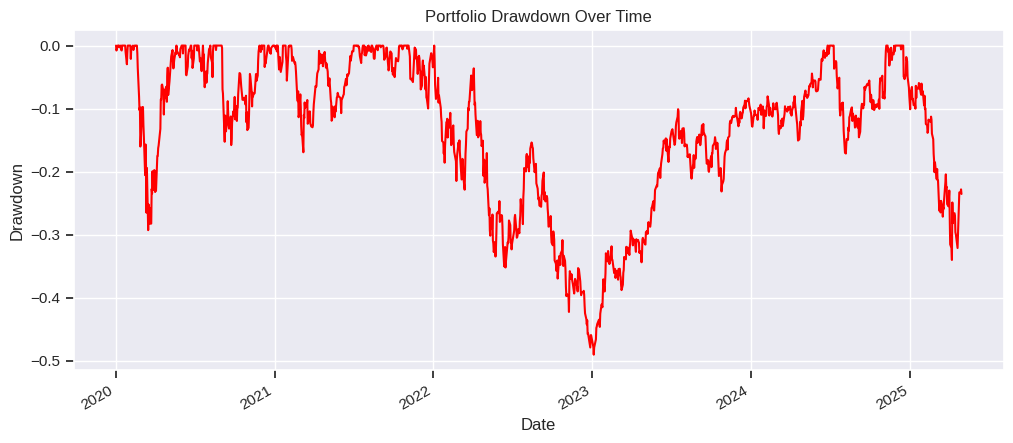

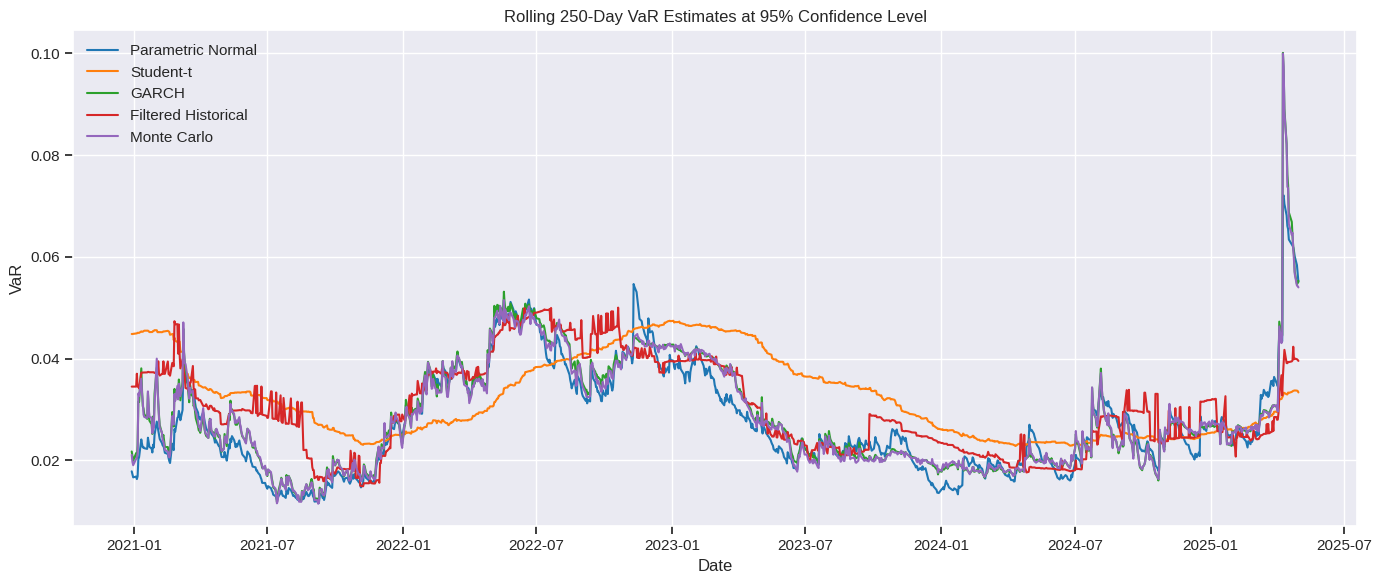

INFO:__main__:
[Enhanced Backtesting of Multiple VaR Models]
INFO:__main__:
                  Model  Breaches  Expected  Breach Rate  Kupiec p-value  Acceptable
0     Parametric Normal        67     54.45     0.061524        0.091615        True
1  Parametric Student-t        52     54.45     0.047750        0.731512        True
2                 GARCH        57     54.45     0.052342        0.724853        True
3   Filtered Historical        50     54.45     0.045914        0.530659        True
4           Monte Carlo        60     54.45     0.055096        0.447399        True


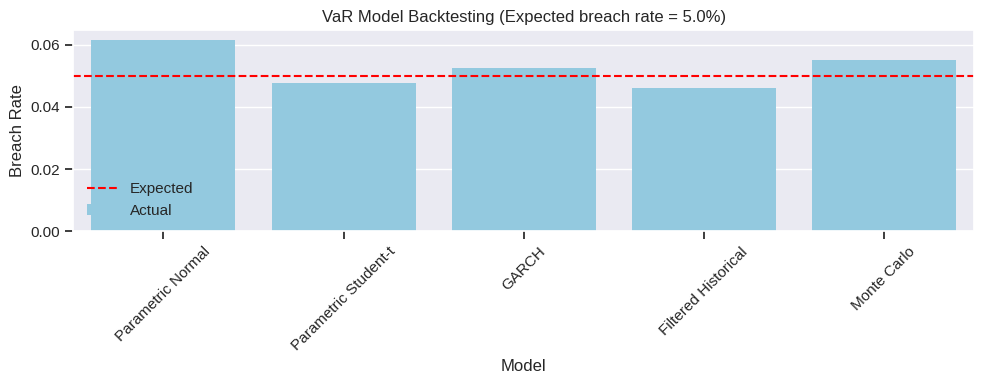

In [1]:
# -------------------------
# Import Libraries
# -------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, chi2, t
from arch import arch_model
from pyextremes import get_extremes
import logging
import os

# -------------------------
# Configure logging
# -------------------------
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# -------------------------
# Log to file
# -------------------------
file_handler = logging.FileHandler('risk_report.log')
file_handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# -------------------------
# Plotting style
# -------------------------
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context('notebook')

# -------------------------
# Data Loading Functions
# -------------------------
def fetch_data_from_csv(file_path):
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    df = df.sort_index()
    return df

def calculate_returns(prices):
    returns = prices.pct_change().dropna()
    return returns

# -------------------------
# Enhanced VaR Calculations
# -------------------------
def var_historical(returns, alpha=0.05):
    return -np.percentile(returns, 100 * alpha)

def var_parametric(returns, alpha=0.05):
    mu = returns.mean()
    lambda_ = 0.94
    ewma_vol = returns.ewm(span=(2/(1-lambda_)-1)).std().iloc[-1]
    return -norm.ppf(alpha, mu, ewma_vol)


def var_student_t(returns, alpha=0.05):
    trimmed = returns.clip(lower=returns.quantile(0.01), upper=returns.quantile(0.99))
    df_fixed = 7
    mu = trimmed.mean()
    sigma = trimmed.std(ddof=1)
    t_quantile = t.ppf(alpha, df_fixed)
    var = -(mu + sigma * t_quantile)
    return var



def var_garch(returns, alpha=0.05):
    try:
        scaled_returns = returns * 100
        
        model = arch_model(scaled_returns, vol='Garch', p=1, q=1, rescale=False)
        res = model.fit(disp='off')
        forecasts = res.forecast(horizon=1)
        pred_vol = np.sqrt(forecasts.variance.values[-1,0]) / 100  # Scale back
        
        return -(returns.mean() + norm.ppf(alpha) * pred_vol)
    except Exception as e:
        logger.warning(f"GARCH model failed: {str(e)}. Falling back to Student-t VaR")
        return var_student_t(returns, alpha)

def var_filtered_historical(returns, alpha=0.05, window=500):
    standardized_returns = returns / returns.rolling(window).std().shift(1)
    recent_vol = returns.std()
    simulated_returns = standardized_returns.dropna().sample(10000, replace=True) * recent_vol
    return -np.percentile(simulated_returns, 100 * alpha)

def var_monte_carlo(returns, alpha=0.05, simulations=10000):
    scaled_returns = returns * 100
    model = arch_model(scaled_returns, vol='Garch', p=1, q=1)
    res = model.fit(disp='off')
    
    omega = res.params['omega']
    alpha_1 = res.params['alpha[1]']
    beta_1 = res.params['beta[1]']
    mu = res.params['mu']
    
    last_sigma2 = res.conditional_volatility.iloc[-1]**2
    last_return = scaled_returns.iloc[-1]
    
    sim_returns = []
    for _ in range(simulations):
        z = np.random.normal()
        sigma2 = omega + alpha_1 * last_return**2 + beta_1 * last_sigma2
        sigma = np.sqrt(sigma2)
        r = mu + sigma * z
        sim_returns.append(r / 100)  # scale back

    return -np.percentile(sim_returns, 100 * alpha)



# -------------------------
# Conditional VaR (CVaR)
# -------------------------
def cvar(returns, alpha=0.05):
    var = np.percentile(returns, 100 * alpha)
    return -returns[returns <= var].mean()

# -------------------------
# 10-day VaR calculations
# -------------------------
def ten_day_var(one_day_var):
    return one_day_var * np.sqrt(10)

def true_10_day_var_mc(returns, alpha=0.05, simulations=10000, horizon=10):
    df, mu, sigma = t.fit(returns)
    daily_returns = t.rvs(df, mu, sigma, (simulations, horizon))
    compounded_returns = np.prod(1 + daily_returns, axis=1) - 1
    var_10d = -np.percentile(compounded_returns, 100 * alpha)
    return var_10d

# -------------------------
# Performance Metrics
# -------------------------
def sharpe_ratio(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    return excess_returns.mean() / excess_returns.std()

def max_drawdown(prices, weights):
    portfolio_value = prices.dot(weights)
    running_max = portfolio_value.cummax()
    drawdown = (portfolio_value - running_max) / running_max
    return drawdown.min()

# -------------------------
# Stress Testing
# -------------------------
def stress_test(portfolio_returns, shock=-0.05):
    stressed_returns = portfolio_returns + shock
    return stressed_returns.mean()

# -------------------------
# Risk Contribution Analysis
# -------------------------
def incremental_var(returns, weights, alpha=0.05):
    base_var = var_student_t(returns.dot(weights), alpha)
    inc_var = {}
    for i, ticker in enumerate(returns.columns):
        new_weights = weights.copy()
        new_weights[i] += 0.01
        new_weights /= new_weights.sum()
        new_var = var_student_t(returns.dot(new_weights), alpha)
        inc_var[ticker] = new_var - base_var
    return inc_var

# -------------------------
# Visualization Functions
# -------------------------
def plot_return_distribution(returns, alpha_levels):
    plt.figure(figsize=(12, 5))
    
    mu, sigma = norm.fit(returns)
    df, t_mu, t_sigma = t.fit(returns)
    
    sns.histplot(returns, bins=100, stat='density', alpha=0.6, color='skyblue')
    
    x = np.linspace(returns.min(), returns.max(), 1000)
    plt.plot(x, norm.pdf(x, mu, sigma), label='Normal', color='green')
    plt.plot(x, t.pdf(x, df, t_mu, t_sigma), label=f'Student-t (df={df:.2f})', color='red')
    
    plt.title("Distribution of Daily Portfolio Returns with Fitted Distributions")
    plt.xlabel("Daily Return")
    plt.ylabel("Density")
    for alpha in alpha_levels:
        for model, color in [('Normal', 'green'), ('Student-t', 'red')]:
            if model == 'Normal':
                var_value = -norm.ppf(alpha, mu, sigma)
            else:
                var_value = -t.ppf(alpha, df, t_mu, t_sigma)
            plt.axvline(x=var_value, color=color, linestyle='--', 
                       label=f'{model} VaR {int((1-alpha)*100)}%')
    
    plt.legend()
    plt.savefig("plots/return_distribution.png", bbox_inches='tight')
    plt.show()
    plt.close()

def plot_garch_volatility(returns):
    try:
        scaled_returns = returns * 100  
        model = arch_model(scaled_returns, vol='Garch', p=1, q=1)
        res = model.fit(disp='off')
        
        plt.figure(figsize=(12, 5))
        plt.plot(returns.index, res.conditional_volatility / 100)  
        plt.title('GARCH Conditional Volatility')
        plt.ylabel('Volatility')
        plt.xlabel('Date')
        plt.grid(True)
        plt.savefig("plots/garch_volatility.png", bbox_inches='tight')
        plt.show()
        plt.close()
    except Exception as e:
        logger.error(f"Could not plot GARCH volatility: {str(e)}")

def plot_risk_contributions(returns, weights):
    cov_matrix = returns.cov()
    portfolio_std = np.sqrt(weights.T @ cov_matrix @ weights)
    marginal_contribs = cov_matrix @ weights / portfolio_std
    contribs = weights * marginal_contribs

    plt.figure(figsize=(8, 1))
    sns.heatmap(contribs.values.reshape(1, -1), annot=True, cmap="Reds",
                xticklabels=returns.columns, yticklabels=["Risk Contribution"])
    plt.title("Heatmap of Risk Contribution by Asset")
    plt.savefig("plots/risk_contributions.png", bbox_inches='tight')
    plt.show()
    plt.close()

def plot_drawdown(prices, weights):
    portfolio_value = prices.dot(weights)
    running_max = portfolio_value.cummax()
    drawdown = (portfolio_value - running_max) / running_max

    plt.figure(figsize=(12, 5))
    drawdown.plot(color='red')
    plt.title('Portfolio Drawdown Over Time')
    plt.xlabel('Date')
    plt.ylabel('Drawdown')
    plt.grid(True)
    plt.savefig("plots/drawdown.png", bbox_inches='tight')
    plt.show()
    plt.close()

def plot_var_comparison(returns, alpha=0.05, window=250):
    models = {
        'Parametric Normal': var_parametric,
        'Student-t': var_student_t,
        'GARCH': var_garch,
        'Filtered Historical': lambda x, a: var_filtered_historical(x, a, window//2),
        'Monte Carlo': var_monte_carlo
    }

    var_df = pd.DataFrame(index=returns.index)

    for name, model in models.items():
        try:
            var_series = returns.rolling(window).apply(lambda x: model(x, alpha), raw=False)
            var_df[name] = var_series
        except Exception as e:
            logger.warning(f"Skipping {name} due to error: {str(e)}")

    var_df = var_df.dropna()

    plt.figure(figsize=(14, 6))
    for column in var_df.columns:
        plt.plot(var_df.index, var_df[column], label=column)

    plt.title(f'Rolling {window}-Day VaR Estimates at {int((1-alpha)*100)}% Confidence Level')
    plt.xlabel('Date')
    plt.ylabel('VaR')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("plots/var_model_comparison.png", bbox_inches='tight')
    plt.show()
    plt.close()


# -------------------------
# Enhanced Backtesting
# -------------------------
def kupiec_test(num_exceptions, num_obs, alpha):
    if num_exceptions == 0:
        LR = -2 * np.log(((1-alpha)**num_obs))
    elif num_exceptions == num_obs:
        LR = -2 * np.log((alpha**num_obs))
    else:
        pi_hat = num_exceptions / num_obs
        LR = -2 * (np.log((1-alpha)**(num_obs-num_exceptions) * alpha**num_exceptions) - 
                 np.log((1-pi_hat)**(num_obs-num_exceptions) * pi_hat**num_exceptions))
    return 1 - chi2.cdf(LR, df=1)

def backtest_var_models(returns, alpha=0.05, window=250):
    
    logger.info("\n[Enhanced Backtesting of Multiple VaR Models]")
    
    models = {
        'Parametric Normal': var_parametric,
        'Parametric Student-t': var_student_t,
        'GARCH': var_garch,
        'Filtered Historical': var_filtered_historical,
        'Monte Carlo': var_monte_carlo
    }
    
    results = []
    
    for model_name, model_func in models.items():
        try:
            if model_name == 'Filtered Historical':
                var_series = returns.rolling(window).apply(lambda x: model_func(x, alpha, window//2))
            else:
                var_series = returns.rolling(window).apply(lambda x: model_func(x, alpha))
            
            aligned_returns = returns[var_series.notna()]
            var_series = var_series.dropna()
            
            breaches = aligned_returns < -var_series
            num_breaches = breaches.sum()
            num_obs = len(breaches)
            
            p_value = kupiec_test(num_breaches, num_obs, alpha)
            
            results.append({
                'Model': model_name,
                'Breaches': num_breaches,
                'Expected': alpha * num_obs,
                'Breach Rate': num_breaches / num_obs,
                'Kupiec p-value': p_value,
                'Acceptable': p_value > 0.05
            })
            
        except Exception as e:
            logger.error(f"Error testing {model_name}: {str(e)}")
            continue

    results_df = pd.DataFrame(results)
    logger.info("\n" + results_df.to_string())
    
    plt.figure(figsize=(10, 4))
    sns.barplot(data=results_df, x='Model', y='Breach Rate', color='skyblue', label='Actual')
    plt.axhline(y=alpha, color='red', linestyle='--', label='Expected')
    plt.title(f'VaR Model Backtesting (Expected breach rate = {alpha:.1%})')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig("plots/backtesting_results.png", bbox_inches='tight')
    plt.show()
    plt.close()
    
    return results_df

# -----------------------------
# Main Execution
# -----------------------------
def main():
    
    os.makedirs("plots", exist_ok=True)
    
    file_path = "tiingo_adjusted_close.csv"
    tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
    weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
    
    assert np.isclose(weights.sum(), 1.0), "Portfolio weights must sum to 1."
    assert len(tickers) == len(weights), "Mismatch between number of tickers and weights."

    prices = fetch_data_from_csv(file_path)[tickers]
    returns = calculate_returns(prices)
    portfolio_returns = returns.dot(weights)

    alpha_levels = [0.05, 0.01]

    for alpha in alpha_levels:
        logger.info(f"\n[VaR Results at {int((1-alpha)*100)}% Confidence Level]")
        models = {
            'Historical': var_historical,
            'Parametric Normal': var_parametric,
            'Parametric Student-t': var_student_t,
            'GARCH': var_garch,
            'Filtered Historical': var_filtered_historical,
            'Monte Carlo': var_monte_carlo
        }
        
        for name, model in models.items():
            try:
                var = model(portfolio_returns, alpha)
                logger.info(f"{name:<20}: ${var:.6f}")
            except Exception as e:
                logger.error(f"Error calculating {name} VaR: {str(e)}")

        logger.info(f"CVaR: {'':<16}${cvar(portfolio_returns, alpha):.6f}")
        logger.info(f"10-day VaR (sqrt): {'':<6}${ten_day_var(var_student_t(portfolio_returns, alpha)):.6f}")
        logger.info(f"True 10-day MC VaR: {'':<7}${true_10_day_var_mc(portfolio_returns, alpha):.6f}")

    logger.info(f"\n[Performance Metrics]")
    logger.info(f"Sharpe Ratio: {sharpe_ratio(portfolio_returns):.4f}")
    logger.info(f"Max Drawdown: {max_drawdown(prices, weights):.4f}")
    logger.info(f"Stress Test (5% shock): ${stress_test(portfolio_returns):.6f}")

    inc_var = incremental_var(returns, weights, alpha=0.05)
    logger.info("\n[Incremental VaR at 95% confidence]")
    for ticker, inc in inc_var.items():
        logger.info(f"{ticker}: ${inc:.8f}")

    plot_return_distribution(portfolio_returns, alpha_levels)
    plot_garch_volatility(portfolio_returns)  
    plot_risk_contributions(returns, weights)
    plot_drawdown(prices, weights)
    plot_var_comparison(portfolio_returns, alpha=0.05, window=250)

    
    backtest_results = backtest_var_models(portfolio_returns, alpha=0.05, window=250)

if __name__ == "__main__":
    main()